# Note:

### I ran this assignment in two parts because I was facing errors in Kaggle printing output for 10000 epochs for Problem 4.  
### Part 1: Problems 1, 2, 3
### Part 2: Problem 4 - In this part I trained the model for 10000 epochs by splitting into 5000 epochs each to avoid crashing of the kernel. 

!pip install librosa numpy tensorflow soundfile

!pip install tensorflow-addons[tensorflow]

In [4]:
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import soundfile as sf
import IPython
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

2024-10-15 23:26:19.015589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 23:26:19.015661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 23:26:19.017168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

# Problem 1

In [6]:
s, sr = librosa.load('/kaggle/input/dls-02-data/train_clean_male.wav', sr = None)
S = librosa.stft(s, n_fft = 1024, hop_length = 512)
S_mag = np.abs(S)

sn, sr = librosa.load('/kaggle/input/dls-02-data/train_dirty_male.wav', sr = None)
X = librosa.stft(sn, n_fft = 1024, hop_length = 512)
X_mag = np.abs(X)

val_s, val_sr = librosa.load('/kaggle/input/dls-02-data/test_s_01.wav', sr = None)
val_S = librosa.stft(val_s, n_fft = 1024, hop_length = 512)
S_mag_val = np.abs(val_S)

val_sn, val_sr = librosa.load('/kaggle/input/dls-02-data/test_x_01.wav', sr = None)
val_X = librosa.stft(val_sn, n_fft = 1024, hop_length = 512)
X_mag_val = np.abs(val_X)

In [7]:
IPython.display.Audio('/kaggle/input/dls-02-data/test_x_02.wav')

In [8]:
x_train = X_mag.T # train noisy signal
y_train = S_mag.T # train clean signal
x_val = X_mag_val.T # test noisy signal
y_val = S_mag_val.T # test clean signal

In [9]:
def calc_snr(clean, denoised):
    clean, denoised = tf.cast(clean, dtype=tf.float32), tf.cast(denoised, dtype=tf.float32)
    num = tf.reduce_sum(tf.square(clean)) + 1e-20
    denom = tf.reduce_sum(tf.square(clean - denoised)) + 1e-20
    snr = 10 * (tf.math.log(num/denom)) / tf.math.log(10.0)
    return snr

In [10]:
calc_snr(y_train, x_train)

<tf.Tensor: shape=(), dtype=float32, numpy=6.9652696>

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(513,)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(513, activation='relu'),
    tf.keras.layers.Dense(513, activation='relu')  # ensure non-negative outputs
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[calc_snr])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              526336    
                                                                 
 dense_1 (Dense)             (None, 513)               525825    
                                                                 
 dense_2 (Dense)             (None, 513)               263682    
                                                                 
Total params: 1315843 (5.02 MB)
Trainable params: 1315843 (5.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val, y_val),
                    epochs=200,
                    batch_size=256)

Epoch 1/200


I0000 00:00:1729029573.791249   13347 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 2s 27ms/step - loss: 0.0668 - calc_snr: 1.8545 - val_loss: 0.1637 - val_calc_snr: 2.3293
Epoch 2/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0334 - calc_snr: 4.8313 - val_loss: 0.1295 - val_calc_snr: 3.3456
Epoch 3/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0215 - calc_snr: 6.5973 - val_loss: 0.1030 - val_calc_snr: 4.3400
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0169 - calc_snr: 7.6635 - val_loss: 0.0890 - val_calc_snr: 4.9731
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0142 - calc_snr: 8.3987 - val_loss: 0.0844 - val_calc_snr: 5.2076
Epoch 6/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0125 - calc_snr: 8.8406 - val_loss: 0.0768 - val_calc_snr: 5.6133
Epoch 7/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0113 - calc_snr: 9.4202 - val_loss: 0.0736 - val_calc_snr: 5.7986
Epoch 8/200
10/10 [=====

In [13]:
s_test, sr_test = librosa.load('/kaggle/input/dls-02-data/test_x_02.wav', sr=None)
S_test = librosa.stft(s_test, n_fft = 1024, hop_length = 512)
S_mag_test = np.abs(S_test)

x_test = S_mag_test.T
y_test = model.predict(x_test)

test_recons = np.multiply(np.divide(S_test, S_mag_test), y_test.T)
test_audio = librosa.istft(test_recons, n_fft = 1024, hop_length = 512)

sf.write('test_recons_02.wav', test_audio, sr_test)

12/12 [==============================] - 0s 2ms/step


In [14]:
IPython.display.Audio('test_recons_02.wav')

In [15]:
IPython.display.Audio('/kaggle/input/dls-02-data/test_x_02.wav')

In [16]:
calc_snr(y_test, x_test)

<tf.Tensor: shape=(), dtype=float32, numpy=8.134872>

# Problem 2

In [17]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(513,1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='leaky_relu', strides=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='leaky_relu', strides=2),
#     tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='leaky_relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(513, activation='leaky_relu', kernel_initializer='he_normal'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[calc_snr])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 256, 128)          512       
                                                                 
 conv1d_1 (Conv1D)           (None, 127, 64)           24640     
                                                                 
 flatten (Flatten)           (None, 8128)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              8324096   
                                                                 
 dense_4 (Dense)             (None, 513)               525825    
                                                                 
Total params: 8875073 (33.86 MB)
Trainable params: 8875073 (33.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
cnn_history = cnn_model.fit(x_train,
                            y_train,
                            epochs=200,
                            batch_size=256,
                            validation_data=(x_val, y_val))

Epoch 1/200
10/10 [==============================] - 2s 52ms/step - loss: 0.0625 - calc_snr: 2.1122 - val_loss: 0.1432 - val_calc_snr: 2.9096
Epoch 2/200
10/10 [==============================] - 0s 12ms/step - loss: 0.0258 - calc_snr: 5.9892 - val_loss: 0.0919 - val_calc_snr: 4.8359
Epoch 3/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0148 - calc_snr: 8.2386 - val_loss: 0.0716 - val_calc_snr: 5.9193
Epoch 4/200
10/10 [==============================] - 0s 12ms/step - loss: 0.0104 - calc_snr: 9.8003 - val_loss: 0.0630 - val_calc_snr: 6.4732
Epoch 5/200
10/10 [==============================] - 0s 12ms/step - loss: 0.0077 - calc_snr: 11.0196 - val_loss: 0.0533 - val_calc_snr: 7.2028
Epoch 6/200
10/10 [==============================] - 0s 12ms/step - loss: 0.0061 - calc_snr: 12.0905 - val_loss: 0.0482 - val_calc_snr: 7.6380
Epoch 7/200
10/10 [==============================] - 0s 11ms/step - loss: 0.0050 - calc_snr: 12.8911 - val_loss: 0.0434 - val_calc_snr: 8.0958
Epo

In [19]:
y_test_cnn = cnn_model.predict(x_test)

test_recons_cnn = np.multiply(np.divide(S_test, S_mag_test), y_test_cnn.T)
test_audio_cnn = librosa.istft(test_recons, n_fft = 1024, hop_length = 512)

sf.write('test_recons_02_cnn.wav', test_audio_cnn, sr_test)

12/12 [==============================] - 0s 7ms/step


In [20]:
IPython.display.Audio('test_recons_02_cnn.wav')

# Problem 3

In [22]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

batch_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
x_train_list, y_train_list = [], []

for batch_file in batch_files:
    train_data = unpickle('/kaggle/input/cifarr/cifar-10-batches-py/' + batch_file)
    x_train_list.append(train_data[b'data'])
    y_train_list.append(train_data[b'labels'])

In [23]:
train_data_images = np.concatenate(x_train_list, axis=0)
train_data_labels = np.concatenate(y_train_list, axis=0)

x_train_images = train_data_images[:-5000]
y_train_labels = np.array(train_data_labels[:-5000])

x_val_images = train_data_images[-5000:]
y_val_labels = np.array(train_data_labels[-5000:])

x_train_images = x_train_images.reshape(45000, 3, 32, 32).transpose(0, 2, 3, 1)
x_val_images = x_val_images.reshape(5000, 3, 32, 32).transpose(0, 2, 3, 1)

x_train_images = (x_train_images / 255.0) * 2 - 1
x_val_images = (x_val_images / 255.0) * 2 - 1

In [24]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_baseline.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 10)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 20)               

In [25]:
history_baseline = model_baseline.fit(x_train_images, 
                                      tf.keras.utils.to_categorical(y_train_labels), 
                                      batch_size=512, 
                                      epochs=200, 
                                      validation_data=(x_val_images, 
                                                       tf.keras.utils.to_categorical(y_val_labels)))

Epoch 1/200
88/88 [==============================] - 3s 15ms/step - loss: 2.2131 - accuracy: 0.1735 - val_loss: 2.0268 - val_accuracy: 0.2774
Epoch 2/200
88/88 [==============================] - 1s 8ms/step - loss: 1.8674 - accuracy: 0.3253 - val_loss: 1.7241 - val_accuracy: 0.3650
Epoch 3/200
88/88 [==============================] - 1s 8ms/step - loss: 1.6272 - accuracy: 0.4108 - val_loss: 1.5562 - val_accuracy: 0.4376
Epoch 4/200
88/88 [==============================] - 1s 8ms/step - loss: 1.4879 - accuracy: 0.4645 - val_loss: 1.4433 - val_accuracy: 0.4824
Epoch 5/200
88/88 [==============================] - 1s 8ms/step - loss: 1.4117 - accuracy: 0.4955 - val_loss: 1.3931 - val_accuracy: 0.5104
Epoch 6/200
88/88 [==============================] - 1s 8ms/step - loss: 1.3660 - accuracy: 0.5118 - val_loss: 1.3585 - val_accuracy: 0.5176
Epoch 7/200
88/88 [==============================] - 1s 7ms/step - loss: 1.3377 - accuracy: 0.5248 - val_loss: 1.3311 - val_accuracy: 0.5294
Epoch 8/200


Text(0.5, 0, 'Epoch')

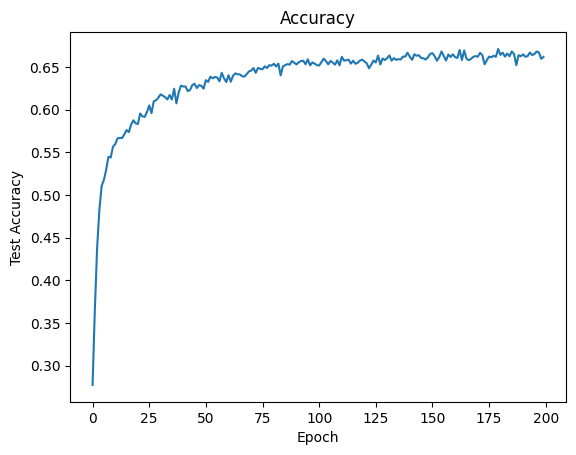

In [26]:
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')

### Augmentation

In [27]:
x_train_images = (x_train_images + 1) / 2.0
x_train_images_brighter = np.minimum(x_train_images * 1.1, 1)
x_train_images_darker = x_train_images * 0.9
x_train_images_flipped = np.flip(x_train_images, axis=2)

In [28]:
x_train_images_all = np.concatenate([x_train_images_brighter, 
                                     x_train_images_darker, 
                                     x_train_images_flipped, 
                                     x_train_images], axis=0)
x_train_images_all = x_train_images_all * 2 - 1

y_train_labels_all = np.tile(y_train_labels, 4)

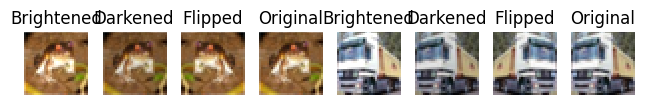

In [29]:
fig, axs = plt.subplots(1, 8)
imgs = [x_train_images_all[0], x_train_images_all[45000], x_train_images_all[90000], x_train_images_all[135000],
        x_train_images_all[1], x_train_images_all[45001], x_train_images_all[90001], x_train_images_all[135001]]
titles = ['Brightened', 'Darkened', 'Flipped', 'Original',
          'Brightened', 'Darkened', 'Flipped', 'Original']

for i in range(8):
    axs[i].imshow(((imgs[i] + 1) / 2 * 255).astype(int))
    axs[i].set_title(titles[i])
    axs[i].axis('off') 

plt.tight_layout()
plt.show()

In [30]:
model_augmented = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_augmented.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_augmented.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 10)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 250)               0         
                                                                 
 dense_7 (Dense)             (None, 20)               

In [31]:
history_augmented = model_augmented.fit(x_train_images_all, 
                                      tf.keras.utils.to_categorical(y_train_labels_all), 
                                      batch_size=512, 
                                      epochs=200, 
                                      validation_data=(x_val_images, 
                                                       tf.keras.utils.to_categorical(y_val_labels)))

Epoch 1/200
352/352 [==============================] - 4s 9ms/step - loss: 1.7231 - accuracy: 0.3774 - val_loss: 1.4459 - val_accuracy: 0.4836
Epoch 2/200
352/352 [==============================] - 3s 7ms/step - loss: 1.3711 - accuracy: 0.5091 - val_loss: 1.3254 - val_accuracy: 0.5236
Epoch 3/200
352/352 [==============================] - 2s 7ms/step - loss: 1.2779 - accuracy: 0.5453 - val_loss: 1.2438 - val_accuracy: 0.5532
Epoch 4/200
352/352 [==============================] - 2s 7ms/step - loss: 1.2145 - accuracy: 0.5716 - val_loss: 1.2016 - val_accuracy: 0.5730
Epoch 5/200
352/352 [==============================] - 3s 7ms/step - loss: 1.1662 - accuracy: 0.5891 - val_loss: 1.1504 - val_accuracy: 0.5954
Epoch 6/200
352/352 [==============================] - 2s 7ms/step - loss: 1.1294 - accuracy: 0.6030 - val_loss: 1.1175 - val_accuracy: 0.6104
Epoch 7/200
352/352 [==============================] - 2s 7ms/step - loss: 1.1004 - accuracy: 0.6143 - val_loss: 1.0950 - val_accuracy: 0.6136

Text(0.5, 0, 'Epoch')

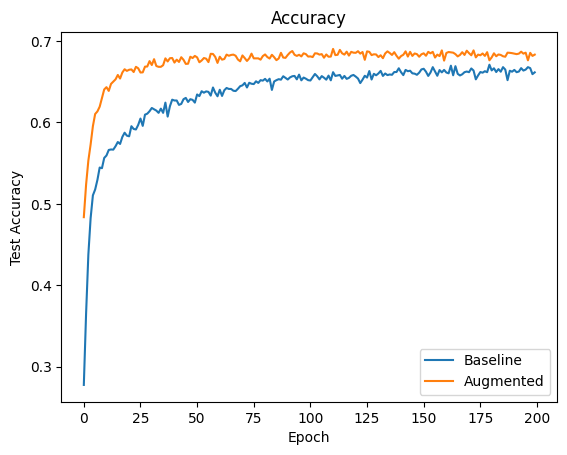

In [32]:
plt.plot(history_baseline.history['val_accuracy'], label="Baseline")
plt.plot(history_augmented.history['val_accuracy'], label="Augmented")
plt.legend()
plt.title('Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')

# Problem 4

In [19]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

batch_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
x_train_list, y_train_list = [], []

for batch_file in batch_files:
    train_data = unpickle('/kaggle/input/cifarr/cifar-10-batches-py/' + batch_file)
    x_train_list.append(train_data[b'data'])
    y_train_list.append(train_data[b'labels'])

In [20]:
train_data_images = np.concatenate(x_train_list, axis=0)
train_data_labels = np.concatenate(y_train_list, axis=0)

class0_images = (train_data_images[:-500].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0) * 2 - 1 
class1_images = np.flip(class0_images, axis=1)
class2_images = np.rot90(class0_images, k=1, axes=(1, 2))

pretext_images = np.concatenate([class0_images, 
                                 class1_images, 
                                 class2_images], axis=0)

class0_labels = [0] * class0_images.shape[0]
class1_labels = [1] * class1_images.shape[0]
class2_labels = [2] * class2_images.shape[0]

pretext_labels = np.concatenate([class0_labels, 
                                 class1_labels, 
                                 class2_labels], axis=0)

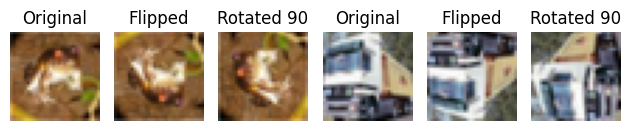

In [21]:
fig, axs = plt.subplots(1, 6)
imgs = [pretext_images[0], pretext_images[49500], pretext_images[99000], 
        pretext_images[1], pretext_images[49501], pretext_images[99001]]
titles = ['Original', 'Flipped', 'Rotated 90',
          'Original', 'Flipped', 'Rotated 90']

for i in range(6):
    axs[i].imshow(((imgs[i] + 1) / 2 * 255).astype(int))
    axs[i].set_title(titles[i])
    axs[i].axis('off') 

plt.tight_layout()
plt.show()

In [22]:
x_train = (train_data_images[-500:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0) * 2 - 1
y_train = train_data_labels[-500:]

test_data = unpickle('/kaggle/input/cifarr/cifar-10-batches-py/test_batch')
x_test = (np.array(test_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0) * 2 - 1
y_test = test_data[b'labels']

In [23]:
model_pretext = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_pretext.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pretext.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 10)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 20)               

In [24]:
history_pretext = model_pretext.fit(pretext_images, 
                                    tf.keras.utils.to_categorical(pretext_labels), 
                                    epochs=100, 
                                    batch_size=512)

Epoch 1/100
291/291 [==============================] - 3s 7ms/step - loss: 0.9148 - accuracy: 0.5425
Epoch 2/100
291/291 [==============================] - 2s 7ms/step - loss: 0.7981 - accuracy: 0.6354
Epoch 3/100
291/291 [==============================] - 2s 7ms/step - loss: 0.7578 - accuracy: 0.6617
Epoch 4/100
291/291 [==============================] - 2s 7ms/step - loss: 0.7312 - accuracy: 0.6779
Epoch 5/100
291/291 [==============================] - 2s 7ms/step - loss: 0.7122 - accuracy: 0.6883
Epoch 6/100
291/291 [==============================] - 2s 8ms/step - loss: 0.6956 - accuracy: 0.6970
Epoch 7/100
291/291 [==============================] - 2s 7ms/step - loss: 0.6815 - accuracy: 0.7035
Epoch 8/100
291/291 [==============================] - 2s 7ms/step - loss: 0.6664 - accuracy: 0.7104
Epoch 9/100
291/291 [==============================] - 2s 7ms/step - loss: 0.6564 - accuracy: 0.7155
Epoch 10/100
291/291 [==============================] - 2s 7ms/step - loss: 0.6455 - accura

In [25]:
model_pretext.save('model_pretext_rerun_pretext_batch_512_2.h5')

In [26]:
model_baseline_2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5), strides=1, kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='he_uniform')
])

model_baseline_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_baseline_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 10)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 250)               0         
                                                                 
 dense_7 (Dense)             (None, 20)               

In [27]:
history_baseline_2_1 = model_baseline_2.fit(x_train, 
                                          tf.keras.utils.to_categorical(y_train), 
                                          epochs=5000, 
                                          batch_size=500, 
                                          validation_data=(x_test, tf.keras.utils.to_categorical(y_test)), 
                                          validation_freq=100)

Epoch 1/5000
1/1 [==============================] - 1s 1s/step - loss: 3.1682 - accuracy: 0.0980
Epoch 2/5000
1/1 [==============================] - 0s 11ms/step - loss: 2.7995 - accuracy: 0.0780
Epoch 3/5000
1/1 [==============================] - 0s 11ms/step - loss: 2.5907 - accuracy: 0.0840
Epoch 4/5000
1/1 [==============================] - 0s 10ms/step - loss: 2.4806 - accuracy: 0.0880
Epoch 5/5000
1/1 [==============================] - 0s 11ms/step - loss: 2.4201 - accuracy: 0.0960
Epoch 6/5000
1/1 [==============================] - 0s 11ms/step - loss: 2.3796 - accuracy: 0.1000
Epoch 7/5000
1/1 [==============================] - 0s 10ms/step - loss: 2.3510 - accuracy: 0.1100
Epoch 8/5000
1/1 [==============================] - 0s 10ms/step - loss: 2.3289 - accuracy: 0.1140
Epoch 9/5000
1/1 [==============================] - 0s 10ms/step - loss: 2.3127 - accuracy: 0.1120
Epoch 10/5000
1/1 [==============================] - 0s 10ms/step - loss: 2.3007 - accuracy: 0.1140
Epoch 11/50

In [28]:
history_baseline_2_2 = model_baseline_2.fit(x_train, 
                                          tf.keras.utils.to_categorical(y_train), 
                                          epochs=5000, 
                                          batch_size=500, 
                                          validation_data=(x_test, tf.keras.utils.to_categorical(y_test)), 
                                          validation_freq=100)

Epoch 1/5000
1/1 [==============================] - 0s 15ms/step - loss: 7.3854e-06 - accuracy: 1.0000
Epoch 2/5000
1/1 [==============================] - 0s 10ms/step - loss: 7.3830e-06 - accuracy: 1.0000
Epoch 3/5000
1/1 [==============================] - 0s 13ms/step - loss: 7.3756e-06 - accuracy: 1.0000
Epoch 4/5000
1/1 [==============================] - 0s 11ms/step - loss: 7.3716e-06 - accuracy: 1.0000
Epoch 5/5000
1/1 [==============================] - 0s 10ms/step - loss: 7.3649e-06 - accuracy: 1.0000
Epoch 6/5000
1/1 [==============================] - 0s 11ms/step - loss: 7.3620e-06 - accuracy: 1.0000
Epoch 7/5000
1/1 [==============================] - 0s 12ms/step - loss: 7.3582e-06 - accuracy: 1.0000
Epoch 8/5000
1/1 [==============================] - 0s 11ms/step - loss: 7.3527e-06 - accuracy: 1.0000
Epoch 9/5000
1/1 [==============================] - 0s 11ms/step - loss: 7.3465e-06 - accuracy: 1.0000
Epoch 10/5000
1/1 [==============================] - 0s 11ms/step - loss:

In [29]:
model_pretext = tf.keras.models.load_model('/kaggle/working/model_pretext_rerun_pretext_batch_512_2.h5')
output_layer = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='he_uniform')(model_pretext.layers[-2].output)

model_transfer_learning = tf.keras.models.Model(inputs=model_pretext.input, outputs=output_layer)

optimizers = [
    tf.keras.optimizers.legacy.Adam(learning_rate=1e-6),
    tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
]
optimizer_layer_map = [(optimizers[0], model_transfer_learning.layers[:-1]), 
                       (optimizers[1], model_transfer_learning.layers[-1])]

optimizer = tfa.optimizers.MultiOptimizer(optimizer_layer_map)
model_transfer_learning.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_transfer_learning.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 10)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 250)               0   

In [30]:
history_transfer_learning_1 = model_transfer_learning.fit(x_train, 
                                                        tf.keras.utils.to_categorical(y_train), 
                                                        epochs=5000, 
                                                        batch_size=500, 
                                                        validation_data=(x_test, tf.keras.utils.to_categorical(y_test)), 
                                                        validation_freq=100)

Epoch 1/5000
1/1 [==============================] - 1s 738ms/step - loss: 3.7833 - accuracy: 0.1240
Epoch 2/5000
1/1 [==============================] - 0s 79ms/step - loss: 3.7658 - accuracy: 0.1260
Epoch 3/5000
1/1 [==============================] - 0s 11ms/step - loss: 3.7484 - accuracy: 0.1260
Epoch 4/5000
1/1 [==============================] - 0s 11ms/step - loss: 3.7311 - accuracy: 0.1260
Epoch 5/5000
1/1 [==============================] - 0s 11ms/step - loss: 3.7139 - accuracy: 0.1280
Epoch 6/5000
1/1 [==============================] - 0s 11ms/step - loss: 3.6968 - accuracy: 0.1260
Epoch 7/5000
1/1 [==============================] - 0s 10ms/step - loss: 3.6797 - accuracy: 0.1260
Epoch 8/5000
1/1 [==============================] - 0s 11ms/step - loss: 3.6628 - accuracy: 0.1260
Epoch 9/5000
1/1 [==============================] - 0s 11ms/step - loss: 3.6460 - accuracy: 0.1240
Epoch 10/5000
1/1 [==============================] - 0s 11ms/step - loss: 3.6293 - accuracy: 0.1260
Epoch 11

In [31]:
history_transfer_learning_2 = model_transfer_learning.fit(x_train, 
                                                        tf.keras.utils.to_categorical(y_train), 
                                                        epochs=5000, 
                                                        batch_size=500, 
                                                        validation_data=(x_test, tf.keras.utils.to_categorical(y_test)), 
                                                        validation_freq=100)

Epoch 1/5000
1/1 [==============================] - 0s 15ms/step - loss: 1.2045 - accuracy: 0.5480
Epoch 2/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2044 - accuracy: 0.5480
Epoch 3/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2044 - accuracy: 0.5480
Epoch 4/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2043 - accuracy: 0.5480
Epoch 5/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2042 - accuracy: 0.5480
Epoch 6/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2042 - accuracy: 0.5480
Epoch 7/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2041 - accuracy: 0.5480
Epoch 8/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2040 - accuracy: 0.5480
Epoch 9/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2040 - accuracy: 0.5480
Epoch 10/5000
1/1 [==============================] - 0s 11ms/step - loss: 1.2039 - accuracy: 0.5480
Epoch 11/

Text(0.5, 0, 'Epochs (*100)')

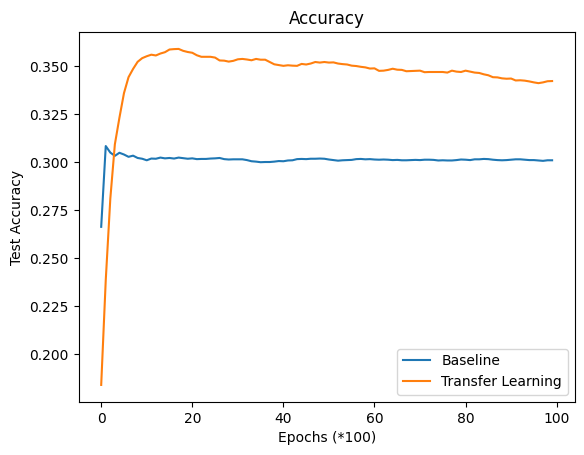

In [32]:
plt.plot(history_baseline_2_1.history['val_accuracy'] +
         history_baseline_2_2.history['val_accuracy'], label='Baseline')
plt.plot(history_transfer_learning_1.history['val_accuracy'] +
         history_transfer_learning_2.history['val_accuracy'], label='Transfer Learning')
plt.legend()
plt.title('Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epochs (*100)')
